<a href="https://colab.research.google.com/github/GiuseTripodi/ImageAndTextAnalysis/blob/main/notebooks/ML_project_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification and anomaly detection

**Author:** [Giuseppe Tripodi](https://www.linkedin.com/in/giuseppe-tripodi-unical/)<br>
**Date created:** 2022/09/19<br>
**Description:** Text Analysis

# Introduction

The goal of the project is to implement a machine learning system
through the use of the Python programming language. A dataset of text will be analyzed.

The following tasks are to be carried out:
* classification
* semi-supervised anomaly detection

#Classification

The models to be evaluated for this task are:

- AdaBoost
- SVM
- Neural Networks
- Density estimation (one among Bayes, Naive Bayes, LDA, GMM, KDE, KNN)

At least one classifier must be delivered for each of these techniques;
multiple classifiers belonging to the same family (e.g., a dense network and a convolutional network) can also be delivered if deemed appropriate.

#Anomaly Detection

At least one of the listed techniques should be used for classification.

In this case, the largest class in the dataset should be considered as the main class, and examples of all other classes will constitute the anomalies.

## Generic Details

Model training should be carried out using only the elements of the main class. For detector quality assessment use ROC curves working on the whole dataset (main class plus anomalies).

#Results to show

**Accuracy**

Among the results to be submitted must be the accuracy obtained by *10-fold cross-validation*. Also required is the delivery of the learned models (one per type) and a script that calculates their accuracy on a validation set encoded in the same format as the source data.

**Report**

A written report should be produced, approximately ten pages in length, to which the code should be attached. The report and software should be delivered within 2 days of the discussion date and may be supplemented during the discussion. Slides may be used for the presentation of the project activity, which will last 15 minutes.


# Setup

## Import

In [ ]:
import warnings
import os
import sys
import json
import pandas as pd
import json
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, metrics
from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
from PIL import Image
import cv2
import numpy as np


import numpy as np
import re
import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import seaborn as sns
from sklearn.utils import shuffle
import time

# Load model libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets, preprocessing
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Import Support Vector Classifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.decomposition import PCA
import scipy
import scipy.stats #distributions
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfTransformer


#ADABOOST
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


#SVM
from sklearn.linear_model import SGDClassifier
from sklearn.svm import OneClassSVM
from sklearn import linear_model



#NEURAL NETWORK IMPORT
import sys
from tensorflow.keras.models import Sequential
import os
import pickle
import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
import math
import numpy
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from tensorflow.keras.layers import Dense, Dropout, LSTM, SpatialDropout1D, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten

#Metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics

 
#Kernel Density
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KernelDensity
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors


#plotting package
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay


#Other Technique
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn import preprocessing


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Setting Up Colab

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
#connect to google drive and get the  dataset
from google.colab import drive
drive.mount("/content/gdrive")
os.chdir("/content/gdrive/My Drive/ML_workspace") #set home directory
print(os.getcwd())

Mounted at /content/gdrive
/content/gdrive/My Drive/ML_workspace


In [ ]:
#set the seed to obtain the same results each time
np.random.seed(500)

## Support Functions

In [ ]:
'''
the function takes the model and does the training
model: model to train
X_train: training set
y_train: labels
MODEL_NAME: name of the model
METHOD: method used 
'''

def train_model(model, X_train, y_train, MODEL_NAME, METHOD, rerun:False):
  #check if the model exist
  DIR = "/content/gdrive/MyDrive/ML_workspace/models_text"
  file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.sav'

  exists = os.path.isfile(file_)
  if exists and not rerun:
    with open(file_, "rb") as sav_file:
      model = pickle.load(sav_file)
  else:
    # Train Adaboost Classifer
    model.fit(X_train, y_train)    
    with open(file_,'wb') as sav_file:
      pickle.dump(model, sav_file)
  return model

In [ ]:
def train_neural_network(model, X_train, y_train, X_val, y_val, epochs, MODEL_NAME, METHOD, rerun:False):

  #check if the model exist
  DIR = "/content/gdrive/MyDrive/ML_workspace/models_text"

  file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.hist'
  model_file = f'{DIR}/{METHOD}/{MODEL_NAME}_model.h5'

  exists = os.path.isfile(file_)
  if exists and not rerun:
    with open(file_,'rb') as hist_file:
      history_dict = pickle.load(hist_file)
      model = keras.models.load_model(model_file)
  else:
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data = (X_val, y_val))
    history_dict = history.history
    with open(file_,'wb') as hist_file:
        pickle.dump(history_dict, hist_file)
    model.save(model_file)
  return model, history_dict

In [ ]:
def train_rnn(model, X_train, Y_train, epochs, batch_size, validation_split, MODEL_NAME, METHOD, rerun:False):

  #check if the model exist
  file_ = f'{DIR}/NN/{MODEL_NAME}.hist'
  model_file = f'{DIR}/{METHOD}/{MODEL_NAME}_model.h5'

  exists = os.path.isfile(file_)
  if exists and not rerun:
    with open(file_,'rb') as hist_file:
      history_dict = pickle.load(hist_file)
      model = keras.models.load_model(model_file)
  else:
    #history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=validation_split)
    history_dict = history.history
    with open(file_,'wb') as hist_file:
      pickle.dump(history_dict, hist_file)
    model.save(model_file)
  return model, history_dict

In [ ]:
f = 1
def hist_plot(history_dict, title):
    global f;
    acc = history_dict['accuracy'];
    val_acc = history_dict['val_accuracy'];
    loss = history_dict['loss'];
    epochs = range(1, len(acc) + 1); # 2 3
    plt.figure(f);
    f = f + 1;
    plt.plot(epochs, acc, 'bo', label='Training acc');
    plt.plot(epochs, val_acc, 'b', label='Validation acc');
    plt.title(title);
    eps = 3e-3;
    n = 7;
    ym = np.min([np.min(acc), np.min(val_acc)])-eps;
    yM = np.max([np.max(acc), np.max(val_acc)])+eps;
    yt = np.array([*range(n+1)])*(yM-ym)/n+ym;
    plt.yticks(yt);
    plt.xlabel('Epochs');
    plt.ylabel('Accuracy');
    plt.legend(loc='lower right');
    plt.ion();
    plt.show();
    plt.pause(3.0001);


In [ ]:
#code from https://www.tensorflow.org/text/tutorials/text_classification_rnn
def plot_graphs(history_dict, metric):
  plt.plot(history_dict[metric])
  plt.plot(history_dict['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
def print_stats(y_true, y_pred):
  print("Accuracy:", "%.2f" % ( metrics.accuracy_score(y_true, y_pred) * 100))
  print('F1: ', "%.2f" % (metrics.f1_score(y_true, y_pred, average='weighted') * 100 )) 
  print('Precision: ', "%.2f" % (metrics.precision_score(y_true, y_pred, average='weighted') * 100 )) 
  print('Recall: ', "%.2f" % (metrics.recall_score(y_true, y_pred, average='weighted') * 100 ))

# Load Data

## Create the dataset

In [ ]:
path = "/content/gdrive/MyDrive/ML_workspace/Dataset/testi-3/testi-3/testi-3.xlsx"
data = pd.read_excel(path)
X = data["cleaned_website_text"]
y = data["Category"]

In [ ]:
data.head()

,cleaned_website_text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel


In [ ]:
data["cleaned_website_text"][0]

'official site good hotel accommodation big saving hotel destination worldwide browse hotel review find guarantee good price hotel budget lodging accommodation hotel hotels special offer package special weekend break city break deal budget cheap discount saving select language find deal hotel home try search connect traveller india travel talk community recommend destination flamborough boreland colvend catfield harberton warleggan inspiration trip spot winter wildlife beautiful snowy island bye bye work want spontechnaity tech drive travel vital value maximise travel homes guest love browse property type hotels apartments resorts villa cabins cottage glamping serviced apartment holiday home guest house hostels motels ryokans riads holiday park homestays campsites country house farm stay boats luxury tent self catering accommodation tiny house chapel saint leonards wuqing wuchang saint eval great rowsley instow verified review real guest work start booking follow trip finally review sk

In [ ]:
data.shape

(1376, 2)

In [ ]:
N_CLASSES = data['Category'].nunique()
N_CLASSES

14

In [ ]:
CLASS_LABELS = data['Category'].unique()
CLASS_LABELS

array(['Travel', 'Social Networking and Messaging', 'News',
       'Streaming Services', 'Sports', 'Photography',
       'Law and Government', 'Health and Fitness', 'Games', 'E-Commerce',
       'Food', 'Education', 'Computers and Technology',
       'Business/Corporate'], dtype=object)

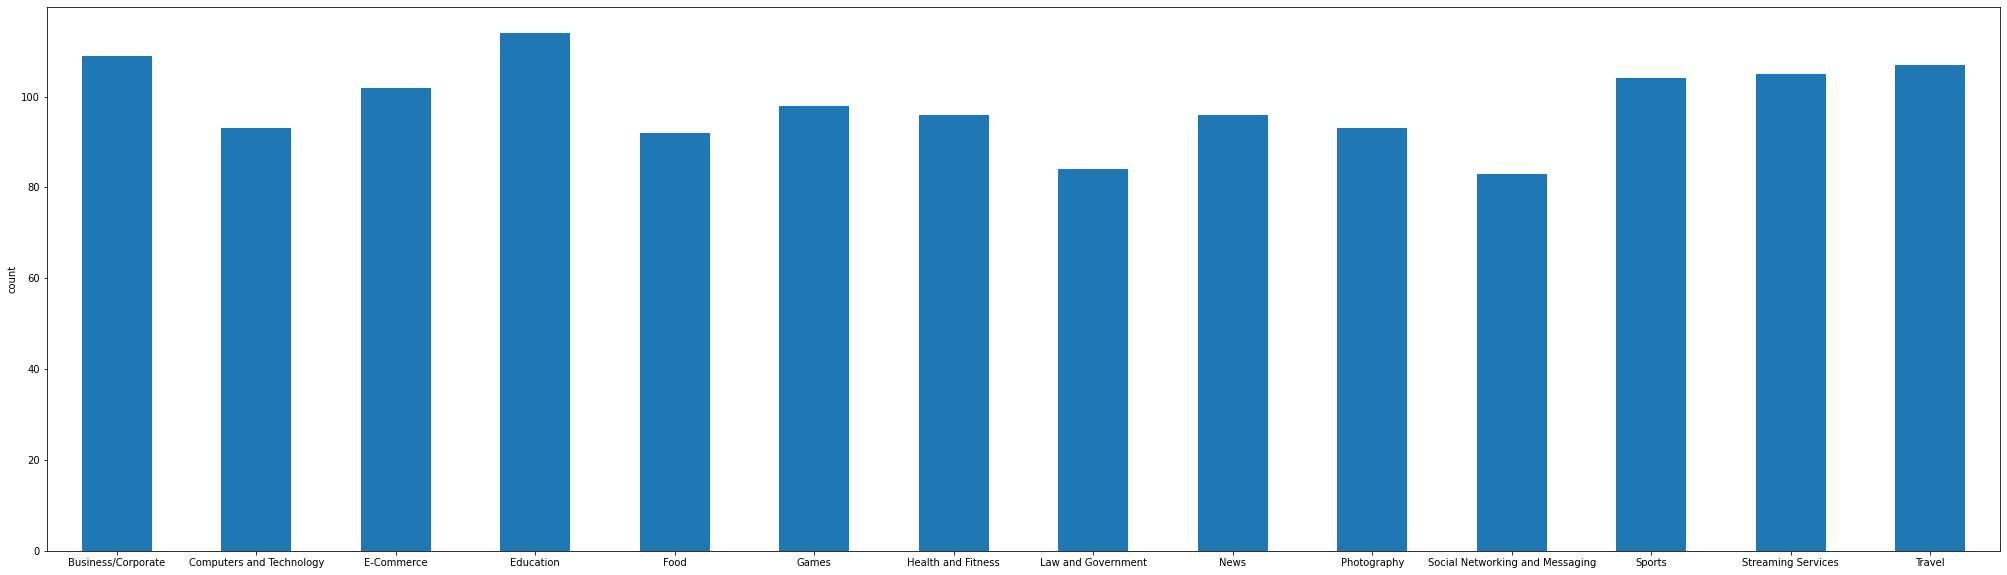

In [ ]:
data['Category'].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count', figsize=(35,10))
plt.show()

In [ ]:
data['Category'].value_counts().sort_index()

Business/Corporate                 109
Computers and Technology            93
E-Commerce                         102
Education                          114
Food                                92
Games                               98
Health and Fitness                  96
Law and Government                  84
News                                96
Photography                         93
Social Networking and Messaging     83
Sports                             104
Streaming Services                 105
Travel                             107
Name: Category, dtype: int64

## Preprocessing: Extracting features from text files

I will remove all unwanted special characters, numbers and spaces from our text.

In [ ]:
#code from https://stackabuse.com/text-classification-with-python-and-scikit-learn/
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    documents.append(document)

To perform machine learning on text documents, we must first transform the text content into numerical feature vectors.

The final preprocessing step is lemmatization. In lemmatization, we reduce the word to the dictionary root form. For example, "cats" is converted to "cat." Lemmatization is performed to avoid creating semantically similar but syntactically different features.


In [ ]:
#Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer
count_vect = CountVectorizer(stop_words="english")
X_train_counts = count_vect.fit_transform(documents)
X_train_counts.shape

(1376, 57480)

The bag of words approach works fine for converting text to numbers. However, it has one drawback. It assigns a score to a word based on its occurrence in a particular document. It doesn't take into account the fact that the word might also be having a high frequency of occurrence in other documents as well. TFIDF resolves this issue by multiplying the term frequency of a word by the inverse document frequency

This method transform a count matrix to a normalized tf or tf-idf representation.

In [ ]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_train_counts)

## Training and Testing Sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1000)

I create the dataset that I will use for cross-validation

In [ ]:
X_, y_ = shuffle(X, y)

# Classification

## AdaBoost

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_text"
METHOD = "ADABOOST"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_text/ADABOOST’: File exists


### 1. DecisionTree as Weak Learner

In [ ]:
MODEL_NAME = "ADABOOST_decision_tree_1lv"
RERUN = True

# Create adaboost classifer object
model = AdaBoostClassifier(n_estimators=20000,
                         learning_rate=0.01, random_state=101)

model = train_model(model, X_train, y_train, MODEL_NAME, METHOD ,RERUN )

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_val)

print_stats(y_val, y_pred)

Accuracy: 56.88
F1:  59.85
Precision:  70.99
Recall:  56.88


#### DecisionTree with more level

In [ ]:
MODEL_NAME = "ADABOOST_decision_tree_2lv"
RERUN = False

# Create adaboost classifer object
model = AdaBoostClassifier(n_estimators=5000, base_estimator=DecisionTreeClassifier(max_depth=2),
                         learning_rate=0.5, random_state=101)

model = train_model(model, X_train, y_train, MODEL_NAME, METHOD ,RERUN)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_val)

print_stats(y_val, y_pred)

Accuracy: 42.03
F1:  44.95
Precision:  60.74
Recall:  42.03


#### CrossValidations Accuracy

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation

# Create adaboost classifer object
model = AdaBoostClassifier(n_estimators=1000, base_estimator=DecisionTreeClassifier(max_depth=2),
                         learning_rate=0.5, random_state=101)
scores = cross_val_score(model, X_, y_, cv=cv)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.66 accuracy with a standard deviation of 0.03
mean: 0.6569766211784618
max value: 0.7101449275362319
min value: 0.6159420289855072


### 2. SVC as Weak Learner

In [ ]:
MODEL_NAMES = ["ADABOOST_SCV","ADABOOST_SCV_poly", "ADABOOST_SCV_rbf" ]

#SVC classifier
svc_classifier = [SVC(kernel='linear',gamma='auto'),SVC(kernel='poly',degree=3, gamma='auto'), SVC(kernel='rbf', gamma=0.5, C=0.1) ]

#save the model after the fitting
results = []
for i in range(len(MODEL_NAMES)):
  MODEL_NAME = MODEL_NAMES[i]
  print(f"Model: {MODEL_NAME}")
  svc = svc_classifier[i]
  

  model = AdaBoostClassifier(n_estimators=5000, base_estimator=svc,
                         learning_rate=0.5, algorithm='SAMME')
  
  model = train_model(model, X_train, y_train, MODEL_NAME, METHOD , True)
  
  #Predict the response for test dataset
  y_pred = model.predict(X_val)

  print_stats(y_val, y_pred)

Model: ADABOOST_SCV


### 3. Random Forest (BEST)

Considering the poor performance with the other models, I decided to try another enseble.

In [ ]:
MODEL_NAME = "ADABOOST_random_forest"

model = RandomForestClassifier(random_state=101)
model = train_model(model, X_train, y_train, MODEL_NAME, METHOD ,False)

In [ ]:
#Predict the response for test dataset
y_pred = model.predict(X_val)

print_stats(y_val, y_pred)

Accuracy: 86.59
F1:  86.12
Precision:  87.39
Recall:  86.59


#### Plotting valutation

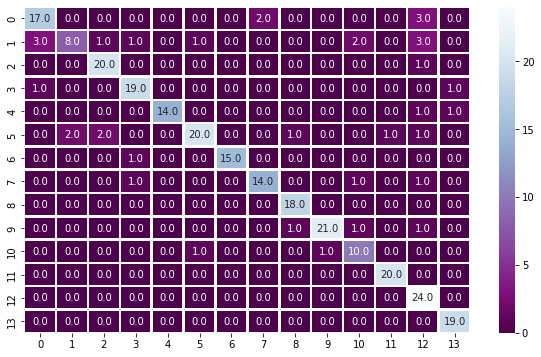

In [ ]:
plt.subplots(figsize=(10,6))
sns.heatmap(confusion_matrix(y_pred=y_pred,y_true=y_val),annot=True,fmt=".1f",linewidths=1.5,cmap="BuPu_r")
plt.show()

#### CrossValidations Accuracy

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation

# Create adaboost classifer object
model = RandomForestClassifier(random_state=101)

scores = cross_val_score(model, X_, y_, cv=cv)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.88 accuracy with a standard deviation of 0.03
mean: 0.8750079339892098
max value: 0.9347826086956522
min value: 0.8333333333333334


## SVM

Support vector machine (SVM) is widely regarded as one of the best text classification algorithms.

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_text"
METHOD = "SVM"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_text/SVM’: File exists


### SGCClassifier

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM)(from [link text](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)).

In [ ]:
MODEL_NAME = "SVM_SGDClassifier"

text_clf = SGDClassifier(random_state=42)

text_clf = train_model(text_clf, X_train, y_train, MODEL_NAME, METHOD ,False)

In [ ]:
y_pred = text_clf.predict(X_val)

print_stats(y_val, y_pred)

Accuracy: 94.57
F1:  94.44
Precision:  94.60
Recall:  94.57


#### Parameter tuning using grid search

In [ ]:
parameters = {'alpha': (1e-1, 1e-2, 1e-3) , "loss": ("hinge", "huber",  "perceptron",)}
text_clf = SGDClassifier( random_state=42, max_iter=5, tol=None)

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

#Let’s perform the search on a smaller subset of the training data to speed up the computation:
gs_clf = gs_clf.fit(X_train, y_train)

In [ ]:
print(f"best score: {gs_clf.best_score_}")
print(f"best params: {gs_clf.best_params_}")

best score: 0.9354545454545453
best params: {'alpha': 0.001, 'loss': 'hinge'}


In [ ]:
best_estimator = gs_clf.best_estimator_

y_pred = best_estimator.predict(X_val)
print_stats(y_val, y_pred)

Accuracy: 94.56521739130434
F1 (SGCClassifier):  94.44


#### CrossValidations Accuracy

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation

# Create SGD classifer object
model = SGDClassifier(loss='hinge', alpha=0.001, random_state=42, max_iter=5, tol=None)


scores = cross_val_score(model, X_, y_, cv=cv)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.94 accuracy with a standard deviation of 0.01
mean: 0.9411456680418915
max value: 0.9565217391304348
min value: 0.9202898550724637


## Neural Network

### Setup

#### Sytem Setup

In [ ]:
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_text"
METHOD = "NN"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_text/NN’: File exists


In [ ]:
#convert the sparse matrix to a dense matrix
X_train = X_train.toarray().astype(float)
X_val = X_val.toarray().astype(float)

In [ ]:
le = preprocessing.LabelEncoder()

y_train_ = le.fit(y_train)

y_train_ = le.transform(y_train)
y_val_ = le.transform(y_val)

### Dense Network

#### Test 1: Dense Network 3 x 16

##### Build and Train the model

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=X_train.shape[1]),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(N_CLASSES, activation='softmax')
]);

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']);


In [ ]:
MODEL_NAME = "NN_dense_2"
epochs=20
rerun = True

model, history_dict = train_neural_network(model, X_train, y_train_, X_val, y_val_, epochs, MODEL_NAME, METHOD, rerun)

##### Valutation Model

I decided to use the validation data as a validation set during training because that way I am also able to see if the model is actually improving and learning from the data. Using the dataset only for validation in the end would be useless for understanding how the model works.

In [ ]:
#get the last accuracy
test_loss, test_acc = model.evaluate(X_val, y_val_)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

9/9 [==============================] - 0s 5ms/step - loss: 0.4712 - accuracy: 0.8732
Test Loss: 0.47123995423316956
Test Accuracy: 0.8731883764266968


(0.0, 2.751700497046113)

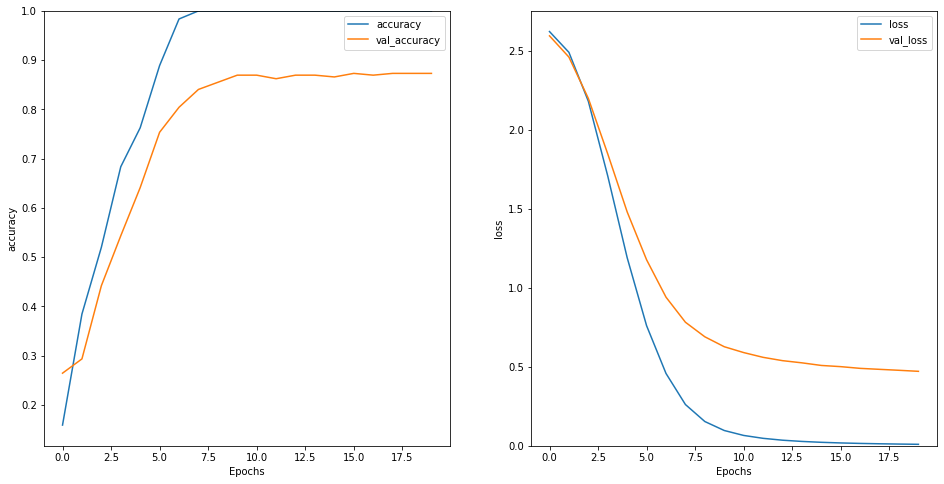

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_dict, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_dict, 'loss')
plt.ylim(0, None)

#### Test 3: Dense Network (Best)

##### Build and Train the model

In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=X_train.shape[1]),
    keras.layers.Dense(1280, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(640, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(320, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(N_CLASSES, activation="softmax"),
])

model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=["accuracy"])

I tried with *mse* loss but the results were very low, with you *sparse_categorical_crossentropy* I got better results.

In [ ]:
MODEL_NAME = "NN_dense_3"
epochs=20

model, history_dict = train_neural_network(model, X_train, y_train_, X_val, y_val_, epochs, MODEL_NAME, METHOD, True)

##### Valutation Model

In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_val_)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

9/9 [==============================] - 0s 8ms/step - loss: 0.2134 - accuracy: 0.9493
Test Loss: 0.213407963514328
Test Accuracy: 0.9492753744125366


(0.0, 2.650968037590792)

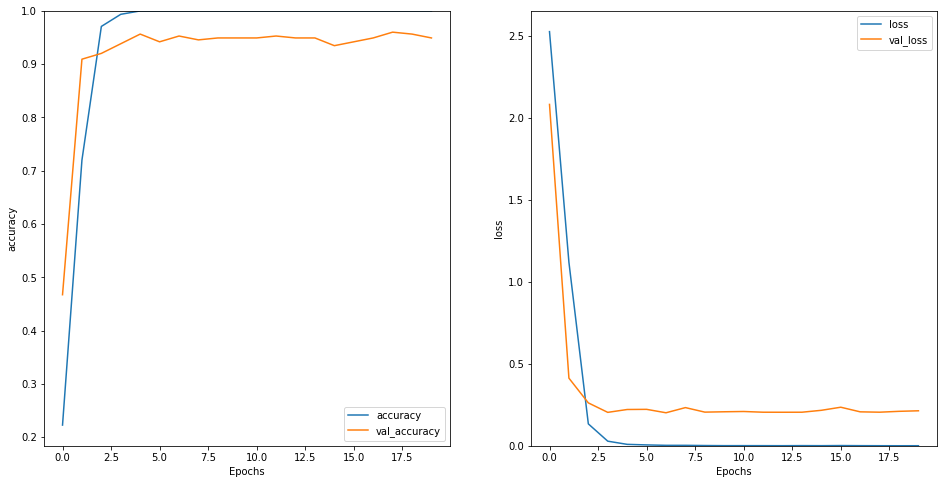

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_dict, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_dict, 'loss')
plt.ylim(0, None)

##### CrossValidations Accuracy

In [ ]:
#join the two array
X_ = np.concatenate((X_train, X_val), axis=0)
y_ = np.concatenate((y_train_, y_val_), axis=0)

#print shape
print(X_.shape)
print(y_.shape)

(1376, 57480)
(1376,)


In [ ]:
# Create function returning a compiled network
def create_network():
  #¢reate the Network
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=X_train.shape[1])),
  model.add(keras.layers.Dense(1280, activation="relu"))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(640, activation="relu"))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(320, activation="relu"))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(N_CLASSES, activation="softmax"))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=["accuracy"])

  return model

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation
epochs = 20
batch_size = 64
verbose = 0

neural_network = KerasClassifier(build_fn = create_network, epochs=epochs, #batch_size=batch_size, 
                                 verbose=verbose)

scores = cross_val_score(neural_network, X_, y_, cv=cv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.94 accuracy with a standard deviation of 0.02
mean: 0.9360361933708191
max value: 0.9637681245803833
min value: 0.9057971239089966


### RNN - Recurrent Neural Network

#### Data Preprocessing

In [ ]:
METHOD = "NN"

In [ ]:
X_RNN = data["cleaned_website_text"]
y_RNN = data["Category"]

The class `Tokenizer` allows to vectorize a text corpus, by turning each text into either a sequence of integers, I also add the value I want to be filtered from the text.

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each phrase.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer =  tf.keras.preprocessing.text.Tokenizer (num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data["cleaned_website_text"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 57648 unique tokens.


In [ ]:
X_RNN = tokenizer.texts_to_sequences(data["cleaned_website_text"].values)
X_RNN = tf.keras.preprocessing.sequence.pad_sequences(X_RNN, maxlen=MAX_SEQUENCE_LENGTH)
Y_RNN = pd.get_dummies(data["Category"]).values

#print shape
print('Shape of data tensor:', X_RNN.shape)
print('Shape of label tensor:', Y_RNN.shape)

Shape of data tensor: (1376, 250)
Shape of label tensor: (1376, 14)


In [ ]:
X_train_RNN, X_test_RNN, Y_train_RNN, Y_test_RNN = train_test_split(X_RNN,Y_RNN, test_size = 0.20, random_state = 42)
print(X_train_RNN.shape,Y_train_RNN.shape)
print(X_test_RNN.shape,Y_test_RNN.shape)

(1100, 250) (1100, 14)
(276, 250) (276, 14)


#### Test 1

##### Define the Model

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(14, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
MODEL_NAME = "NN_RNN_2"
RERUN = False
validation_split = 0.2

epochs = 100
batch_size = 64


model, history_dict = train_rnn(model, X_train_RNN, Y_train_RNN, epochs, batch_size, validation_split, MODEL_NAME, METHOD, RERUN)

##### Results Valutation

In [ ]:
accr = model.evaluate(X_test_RNN,Y_test_RNN)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

9/9 [==============================] - 1s 103ms/step - loss: 3.2322 - accuracy: 0.5290
Test set
  Loss: 3.232
  Accuracy: 0.529


(0.0, 3.934984816928045)

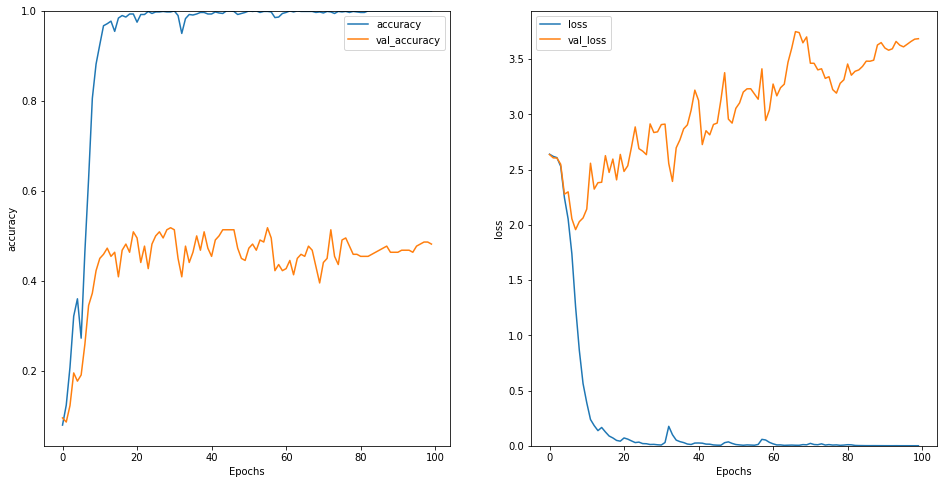

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_dict, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_dict, 'loss')
plt.ylim(0, None)

Model is overfitting the data

## Density Estimation

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_text"
METHOD = "DE"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_text/DE’: File exists


In [ ]:
#convert the sparse matrix to a dense matrix
X_train = X_train.toarray().astype(float)
X_val = X_val.toarray().astype(float)

In [ ]:
le = preprocessing.LabelEncoder()

y_train_ = le.fit(y_train)

y_train_ = le.transform(y_train)
y_val_ = le.transform(y_val)

#### Naive Bayes Classifier Algorithm

##### Multinomial Naive Bayes classifier

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

I also tried the regular NaiveBayes, but the performance was not good enough:
`Naive Bayes accuracy score -> 58.3333333333333333336`


In [ ]:
MODEL_NAME = "MultinomialNB"
RERUN = True

model = MultinomialNB()

model = train_model(model, X_train, y_train_, MODEL_NAME, METHOD ,RERUN)

In [ ]:
# predict the labels on validation dataset
y_pred = model.predict(X_val)

print_stats(y_val_, y_pred)

Accuracy: 88.04
F1:  87.83
Precision:  90.68
Recall:  88.04


###### CrossValidations Accuracy

In [ ]:
X_, y_ = shuffle(X, y)

In [ ]:
#define the paramters
cv = 10 #I want to do 10-fold-cross-validation

# Create adaboost classifer object
model = MultinomialNB()

scores = cross_val_score(model, X_, y_, cv=cv)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
print(f"mean: {scores.mean()}")
print(f"max value: {scores.max()}")
print(f"min value: {scores.min()}")

0.90 accuracy with a standard deviation of 0.02
mean: 0.896091187982651
max value: 0.9343065693430657
min value: 0.8759124087591241


##### Complement Naive Bayes classifier

The Complement Naive Bayes classifier was designed to correct the “severe assumptions” made by the standard Multinomial Naive Bayes classifier. It is particularly suited for imbalanced data sets.

Since the dataset is rather unbalanced, this algorithm is more likely to get better results.


In [ ]:
MODEL_NAME = "ComplementNB"
RERUN = True

model = ComplementNB()

model = train_model(model, X_train, y_train_, MODEL_NAME, METHOD ,RERUN)

###### Metrics Valutation

In [ ]:
# predict the labels on validation dataset
y_pred = model.predict(X_val)# Use accuracy_score function to get the accuracy
print_stats(y_val_, y_pred)

Accuracy: 93.48
F1:  93.31
Precision:  93.61
Recall:  93.48


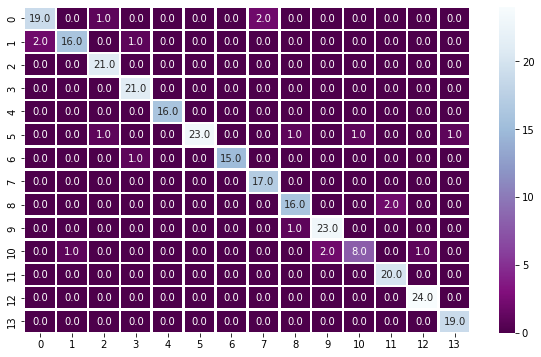

In [ ]:
plt.subplots(figsize=(10,6))
sns.heatmap(confusion_matrix(y_pred=y_pred,y_true=y_val_),annot=True,fmt=".1f",linewidths=1.5,cmap="BuPu_r")
plt.show()

#### KNN

I tried using PCA because the dimensionality is too high, but the results were not bad. I then noticed that without PCA, better results were obtained.

In [ ]:
MODEL_NAME = "NearestNeighbors"
RERUN = False

model = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

model = train_model(model, X_train, y_train_, MODEL_NAME, METHOD ,RERUN)

In [ ]:
# predict the labels on validation dataset
predictions_KNN = model.predict(X_val)
print_stats(y_val_, predictions_KNN)

Accuracy: 89.13
F1:  88.95
Precision:  88.93
Recall:  89.13


##### GridSearch

In [ ]:
params = {"n_neighbors":scipy.stats.randint(1,25), "metric":("euclidean", "manhattan" , "chebyshev")}
neigh = KNeighborsClassifier()


RSC = RandomizedSearchCV(n_iter = 15, estimator = neigh, param_distributions=params)
RSC.fit(X_train, y_train_)

RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=15,
                   param_distributions={'metric': ('euclidean', 'manhattan',
                                                   'chebyshev'),
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9f0fd1b7d0>})

In [ ]:
print(f"Best params: {RSC.best_params_}")
estimator = RSC.best_estimator_

Best params: {'metric': 'euclidean', 'n_neighbors': 10}


In [ ]:
# predict the labels on validation dataset
predictions_KNN = estimator.predict(X_val)# Use accuracy_score function to get the accuracy
predictions_KNN

Naive Bayes Accuracy Score ->  90.94202898550725
F1 (ComplementNB):  90.70
Precision (ComplementNB):  91.15
Recall (ComplementNB):  90.94


#Anomaly Detection

## Setup

### Setup the enviroment

In [ ]:
#create dir 
DIR = "/content/gdrive/MyDrive/ML_workspace/models_text"
METHOD = "ANOMALY_DETECTION"
!mkdir {DIR}/{METHOD}

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ML_workspace/models_text/ANOMALY_DETECTION’: File exists


### Support Functions

In [ ]:
def create_anomaly_detection_dataset(X, y):
  outlier = -1
  inlier = 1

  Y = np.where(y == "Education", inlier, outlier)

  #creating the training set 
  X_train = X[Y==inlier]
  Y_train = Y[Y==inlier]

  #make the validation set
  X_train_, X_val_, Y_train_, Y_val_ = train_test_split(X_train, Y_train, test_size=0.2,  random_state=1000)

  #convert the sparse matrix to a dense matrix
  X_train_ = X_train_.toarray().astype(float)
  X_val_ = X_val_.toarray().astype(float)

  print(len(X_val_))

  #get the other element to append to the validation set
  X_outlier = X[Y == outlier].toarray().astype(float)
  Y_outlier = Y[Y==outlier]

  #append the other elements
  X_val_ = np.concatenate((X_val_, X_outlier), axis=0)
  Y_val_ = np.append(Y_val_, Y_outlier)

  #create the dataset to compute the final AUC on all dataset
  X_test = X.toarray().astype(float)
  Y_test = Y
  
  return X_train_, X_val_, Y_train_, Y_val_, X_test, Y_test


### Create the dataset

In [ ]:
X_train_, X_val_, Y_train_, Y_val_, X_test, Y_test = create_anomaly_detection_dataset(X, y)

23
91
1285


The most numerous class is *Education*, I will use this class as a positive class and the other classes as an outlier, so:
- Education = inlier
- Other classes = anomaly


##SVM

### OneClass SVM

In [ ]:
#parameter
MODEL_NAME = "OneClassSVM"
rerun = True

#model
clf_svm = OneClassSVM(kernel="linear", nu=0.1)

#check if the model exists
file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.sav'
score_file = f'{DIR}/{METHOD}/{MODEL_NAME}_score'

exists = os.path.isfile(file_)
if exists and not rerun:
  with open(file_,'rb') as sav_file:
    clf_svm = pickle.load(sav_file)
    score = np.load(f"{score_file}.npy", allow_pickle=True)
else:
  clf_svm.fit(X_train_)   
  y_score = clf_svm.decision_function(X_val_)
  with open(file_,'wb') as sav_file:
    pickle.dump(clf_svm, sav_file)
    np.save(score_file, y_score)

#### Results Valutation

##### AUC for Model Selection

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(Y_val_, y_score) * 100 )) 

ROC_AUC:  95.51


##### AUC all dataset

In [ ]:
#parameter
MODEL_NAME = "OneClassSVM"
#model
clf_svm = OneClassSVM(kernel="linear", nu=0.1)


#check if the model exists
file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.sav'

with open(file_,'rb') as sav_file:
    clf_svm = pickle.load(sav_file)  
    y_score = clf_svm.decision_function(X_test)

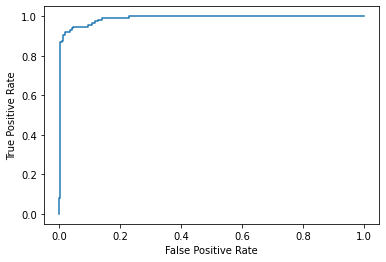

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_score, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(Y_test, y_score) * 100 )) 

ROC_AUC:  98.93


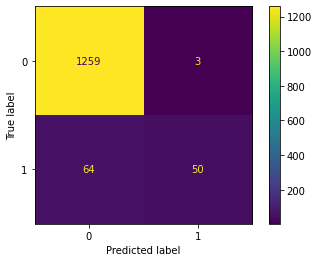

In [ ]:
y_pred = clf_svm.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

### SGDOneClassSVM

In [ ]:
#parameter
MODEL_NAME = "SGDOneClassSVM"
rerun = True

#model
clf = linear_model.SGDOneClassSVM()

#check if the model exists
file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.sav'
score_file = f'{DIR}/{METHOD}/{MODEL_NAME}_score'

exists = os.path.isfile(file_)
if exists and not rerun:
  with open(file_,'rb') as sav_file:
    clf = pickle.load(sav_file)
    score = np.load(f"{score_file}.npy", allow_pickle=True)
else:
  clf.fit(X_train_)   
  y_score = clf.decision_function(X_val_)
  with open(file_,'wb') as sav_file:
    pickle.dump(clf, sav_file)
    np.save(score_file, y_score)

#### Results Valutation

##### AUC for Model Selection

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(Y_val_, y_score) * 100 )) 

ROC_AUC:  95.29


##### AUC all dataset

In [ ]:
#parameter
MODEL_NAME = "SGDOneClassSVM"
#model
clf_svm = OneClassSVM(kernel="linear", nu=0.1)


#check if the model exists
file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.sav'

with open(file_,'rb') as sav_file:
    clf_svm = pickle.load(sav_file)  
    y_score = clf_svm.decision_function(X_test)

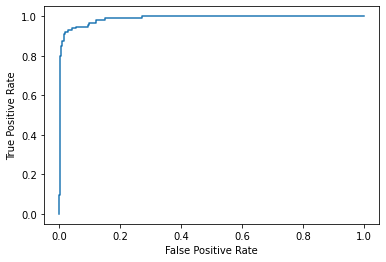

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_score, pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(Y_test, y_score) * 100 )) 

ROC_AUC:  98.86


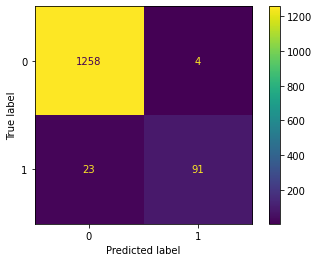

In [ ]:
y_pred = clf_svm.predict(X_test)

cm = confusion_matrix(Y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

## Neural Network

### Setup

#### Prepare the dataset

In [ ]:
#substitute the value -1 for the anomalies with the value 0, this will be useful 
#later for the evalutation of the standard metrics

Y_train_ = np.where(Y_train_ == -1, 0, Y_train_) 
Y_val_ = np.where(Y_val_ == -1, 0, Y_val_) 
Y_test = np.where(Y_test == -1, 0, Y_test) 

### Dense Network

#### Test 1

##### Build and Train the model

In [ ]:
N_CLASSES = 2
model = keras.Sequential([
    keras.layers.Dense(320, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(N_CLASSES, activation="softmax"),
])

model.compile(loss='sparse_categorical_crossentropy', optimizer="Adam", metrics=["accuracy"])

In [ ]:
#paramether defintions
RERUN = True
EPOCHS = 10
VERBOSE = 0
MODEL_NAME = "AN_DENSE_NETWORK"

#----

file_ = f'{DIR}/{METHOD}/{MODEL_NAME}.hist'
model_file = f'{DIR}/{METHOD}/{MODEL_NAME}_model.h5'

exists = os.path.isfile(file_)
if exists and not RERUN:
  with open(file_,'rb') as hist_file:
    history_dict = pickle.load(hist_file)
    model = keras.models.load_model(model_file)
else:
  history = model.fit(X_train_, Y_train_, epochs=EPOCHS, verbose=VERBOSE)
  history_dict = history.history
  with open(file_,'wb') as hist_file:
    pickle.dump(history_dict, hist_file)
  model.save(model_file)

##### Results Valutations

###### AUC

The model is trained to recognize the *normal class* (*inlier*), so the prediction score is the probability of the image to belong to the *inlier class*.

In [ ]:
prediction_score = model.predict(X_test) #probability to belong to the each classes
#extract the probability of an element to stay in the positive class
y_score = prediction_score[:, 1] 

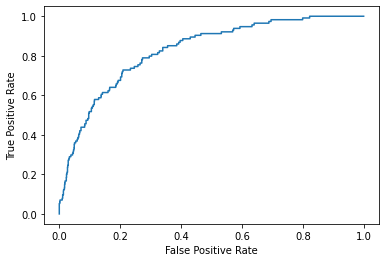

In [ ]:
fpr, tpr, _ = metrics.roc_curve(Y_test, y_score)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
print('ROC_AUC: ', "%.2f" % (roc_auc_score(Y_test, y_score) * 100 )) 


ROC_AUC:  82.72
